# Comparing Ketamine and Midazolam after treatment in ROIs
- Analysis in HPC
- focus on end of treatment
- Amygdala
- vmPFC
- Hippocampus

#### Small explanation for the code for future reference (as it is a bit messy)
- I take all functional files of trauma vs relaxed first script first 1min
- I mask for amygdala - run analysis per session (1,2,3) and calculate effect (using pyMC3)
- I mask for vmPFC and do the same
- I mask for hippocampus and do the same
- Effect reported are amygdala and hippocampus show sig. difference in the post treatment scan. Amygdala shows effect in 30 days f/u hipocampus doesn't. vmPFC and OFC doesn't show anything.

In [1]:
# import relevant packages
import glob
import numpy as np
import scipy
import nilearn
import nilearn.image
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az
from pymc3.glm import GLM

In [32]:
# Set session
ses = 1
## Grab group
# compare between groups

medication_cond = pd.read_csv('/home/oad4/kpe_task/task_based_analysis/kpe_sub_condition.csv')

func_files = glob.glob('/gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses%s/modelfit/_subject_id_*/modelestimate/results/cope7.nii.gz' %(ses))

func_files.sort()
len(func_files)

27

In [26]:
# remove 1315
del func_files[6] #(only session 1,2)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


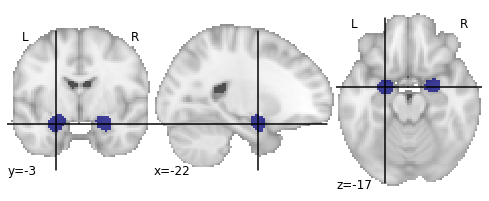

In [33]:
## Amygdala as mask
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=25", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)


masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                                smoothing_fwhm=None, standardize=False,
                                        detrend=False, verbose=9).fit()

In [34]:

t_arr = []
mean_act = []
scr_id = []
#delayed_get_data = dask.delayed(masker.fit_transform)
for func in func_files:
    # get subject number
    scr_id.append('KPE' + func.split('id_')[1].split('/')[0])
    # get average activation
    t_map = masker.transform(func)
    t_arr.append(np.mean(t_map, axis=1)[0])
    


[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -

In [18]:
df_ses3 = []
df_ses3 = pd.DataFrame({'scr_id': scr_id, 'amg3': t_arr})
df_ses3 = pd.merge(medication_cond, df_ses3)
df_ses3 = df_ses3.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df_ses3 = df_ses3.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

In [19]:
df_ses3.groupby('group').describe(percentiles=[.025, 0.975])
#df_ses3.groupby('group').median()

amg3                                                        \
          count       mean        std        min       2.5%       50%   
group                                                                   
ketamine   12.0  -8.098831  25.731792 -51.072002 -50.790543 -8.087476   
midazolam  10.0  13.700760  29.060242 -17.359652 -17.300258  5.920708   

                                 
               97.5%        max  
group                            
ketamine   27.843633  30.116594  
midazolam  62.286746  63.315742

In [10]:
df_ses2 = []
df_ses2 = pd.DataFrame({'scr_id': scr_id, 'amg2': t_arr})
df_ses2 = pd.merge(medication_cond, df_ses2)
df_ses2 = df_ses2.rename(columns={'med_cond': 'group'})
#df['goup'] = medication_cond['med_cond']
df_ses2 = df_ses2.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

In [11]:
df_ses2.groupby('group').describe(percentiles=[.025, 0.975])
#df_ses2.groupby('group').median()

amg2                                                         \
          count       mean        std        min       2.5%        50%   
group                                                                    
ketamine   13.0 -15.032666  29.394467 -65.085220 -61.711027 -13.578852   
midazolam  12.0  16.262296  21.378270 -18.552002 -18.246505  17.687807   

                                 
               97.5%        max  
group                            
ketamine   25.817412  31.083992  
midazolam  49.952302  56.474892

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Ttest_indResult(statistic=-3.0215528988284044, pvalue=0.00607471293987473)

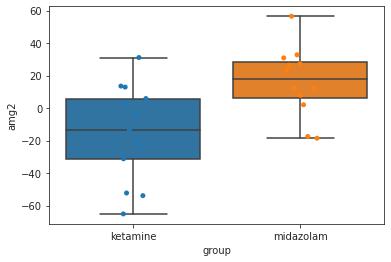

In [12]:
sns.set_style("ticks")
sns.boxplot('group','amg2',data=df_ses2)
sns.stripplot('group','amg2',data=df_ses2)
scipy.stats.ttest_ind(df_ses2.amg2[df_ses2.group=='ketamine'],
                      df_ses2.amg2[df_ses2.group=='midazolam']
                     )

In [13]:
import pingouin as pg

In [14]:
pg.ttest(df_ses2.amg2[df_ses2.group=='ketamine'],
                      df_ses2.amg2[df_ses2.group=='midazolam'])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.06064,21.861834,two-sided,0.005755,"[-52.51, -10.08]",1.209589,8.005,0.82468


In [20]:
pg.ttest(df_ses3.amg3[df_ses3.group=='ketamine'],
                      df_ses3.amg3[df_ses3.group=='midazolam'])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.844862,18.234014,two-sided,0.081365,"[-46.6, 3.0]",0.799108,1.238,0.427365


In [35]:
df_ses1 = []
df_ses1 = pd.DataFrame({'scr_id': scr_id, 'amg1': t_arr})
df_ses1 = pd.merge(medication_cond, df_ses1)
df_ses1 = df_ses1.rename(columns={'med_cond': 'group'})
df_ses1 = df_ses1.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})
#df['group'] = medication_cond['med_cond']

In [36]:

df_ses1.groupby('group').describe(percentiles=[.025, 0.975])

amg1                                                        \
          count       mean        std        min       2.5%       50%   
group                                                                   
ketamine   14.0   0.188137  36.473286 -90.909035 -73.970158  5.279020   
midazolam  13.0  14.000340  41.093906 -28.428524 -26.461765  0.108282   

                                   
                97.5%         max  
group                              
ketamine    45.807860   48.258152  
midazolam  101.605644  110.843590

In [ ]:
df_ses1

In [37]:
df_ses1 = pd.merge(df, df_ses1)
df_ses1['amg_change'] = df_ses1.meanAct - df_ses1.amg1

NameError: name 'df' is not defined

In [ ]:
# this is in case we need to show the lowering of amygdala reactivation before and after treatment
sns.boxplot(y='amg1', x= 'group', data = df_ses1)
sns.stripplot(y='amg1', x= 'group', data = df_ses1)

In [ ]:
df_ses3 = pd.merge(df, df_ses3)
df_ses3

In [ ]:
sns.barplot(x='group',y='amg3', data=df_ses3, ci=95)
#sns.boxplot(x='group',y='meanAct', data=df)
scipy.stats.ttest_ind(df_ses3.amg3[df_ses3['group']=='ketamine'], 
                      df_ses3['amg3'][df_ses3['group']=='midazolam'])

In [ ]:
df_ses1 = []
df_ses1 = pd.DataFrame({'scr_id': scr_id, 'meanAct_ses1': average[0]})
df_ses1 = pd.merge(medication_cond, df_ses1)
df_ses1 = df_ses1.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df_ses1 = df_ses1.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

In [ ]:
group = {'ketamine': 1,'midazolam': 0} 
df_ses3['groupIdx'] =[group[item] for item in df_ses3.group] 

In [38]:
df = []
df = pd.DataFrame({'scr_id': scr_id, 'meanAct': t_arr})
df = pd.merge(medication_cond, df)
df = df.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df = df.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

## Combine all three sessions

In [39]:
df = pd.merge(df_ses1, df_ses2, how='left')
df = pd.merge(df, df_ses3, how='left') # adding that to avoid removing Nan subjects
# add index for group (0 and 1)
group = {'ketamine': 1,'midazolam': 0} 
df['groupIdx'] =[group[item] for item in df.group] 
# save the dataframe
df.to_csv('threeSessions_amg_TraumavsRelax.csv', index = False)

In [40]:
df.groupby(['group']).describe()

amg1                                                        \
          count       mean        std        min        25%       50%   
group                                                                   
ketamine   14.0   0.188137  36.473286 -90.909035 -16.669840  5.279020   
midazolam  13.0  14.000340  41.093906 -28.428524 -13.385894  0.108282   

                                  amg2             ...       amg3             \
                 75%         max count       mean  ...        75%        max   
group                                              ...                         
ketamine   25.230118   48.258152  13.0 -15.032666  ...   7.022264  30.116594   
midazolam  24.746063  110.843590  12.0  16.262296  ...  27.308233  63.315742   

          groupIdx                                     
             count mean  std  min  25%  50%  75%  max  
group                                                  
ketamine      14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
midazolam     13.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 40 columns]

In [ ]:
# plot
sns.barplot(x='group',y='amg2', data=df, ci=95)
#sns.boxplot(x='group',y='meanAct', data=df)
scipy.stats.ttest_ind(df.amg2[df['group']==1], df['amg2'][df['group']==0])

In [ ]:
# test changes betwen sessions
df2ses = pd.merge(df, df_ses1)
df2ses['amg2_1'] = df2ses.meanAct - df2ses.meanAct_ses1


In [ ]:
sns.barplot(x='group',y='amg2_1', data=df2ses, ci=68)
#sns.boxplot(x='group',y='meanAct', data=df)
scipy.stats.ttest_ind(df2ses.amg2_1[df2ses['group']=='ketamine'], 
                      df2ses['amg2_1'][df2ses['group']=='midazolam'])

## Use PyMC3 for bayesian based analysis 

In [41]:
# first code new variable for group index (1=ketamine, 0= midazolam)
group = {'ketamine': 1,'midazolam': 0} 
df['groupIdx'] =[group[item] for item in df.group] 

In [ ]:
# Full model
with pm.Model() as model_1:
    # Data
    group = pm.Data('group', df.groupIdx)
    amg = pm.Data('amg', df.meanAct)
    #ketamine = pm.Data('ketamine', df.meanAct[df['group']=='ketamine'].values)
    #midazolam = pm.Data('midazolam', df.meanAct[df['group']=='midazolam'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=5, sd=5)
    beta = pm.Normal('beta', mu=-5, sd=5)
    sigma = pm.HalfNormal('sigma', sigma=5)
    
    # Regression
    mu = alpha + beta * group
    diff_group = pm.Normal('diff_group', mu=mu, sd=sigma, observed=amg)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_1 = pm.sample(draws=4000, tune=4000) # this is the trace sampling
   # posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

In [ ]:
#az.summary(posterior_1, credible_interval=.95).round(2) # adding round to make shorted floats
pm.summary(posterior_1, hdi_prob=0.95)#, alpha=.05).round(2)# also possible

In [ ]:
# play with glm module of pymc3
with pm.Model() as model_glm:
    GLM.from_formula('amg3 ~ groupIdx', df_ses3)
    trace = pm.sample(draws=5000, tune=3000)

In [ ]:
pm.summary(trace, hdi_prob=.95).round(2)

In [ ]:
pm.plot_posterior(trace['groupIdx'])

In [ ]:
sns.distplot(trace.groupIdx)
sum(trace['groupIdx']>0) / len(trace['groupIdx'])

In [ ]:
# set variables
sns.set_style("ticks") # set style
y = 'meanAct'
dfPlot = df
ci = np.quantile(trace.groupIdx, [.025,.975])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                        'wspace':.1})
g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
            boxprops=dict(alpha=.3))
g2 = sns.distplot(trace['groupIdx'], ax = ax2, vertical=True)
ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
           linewidth = 2, linestyle = "-")

#g3.set_ylim(-.7, .7)
#ax1.set_ylim(-.7,.7)
ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
ax2.yaxis.tick_right()
ax2.set_xticks([])
ax2.set_ylabel("Difference between groups", fontsize=14) 
ax2.yaxis.set_label_position("right")
ax1.set_ylabel("Amg reactivity to traumatic script", fontsize=12)
ax1.set_xlabel("Group", fontsize=14)
fig.savefig('amygdalaReactivity.png', dpi=600, bbox_inches='tight')

### Creating mixed level model

In [42]:
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg1','amg2','amg3'])
df_long.to_csv('amygdala.csv', index=False)

In [48]:
with pm.Model() as model_multilevel:
    

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx:variable[T.amg3], groupIdx:variable[T.amg2], groupIdx, variable[T.amg3], variable[T.amg2], Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.


In [49]:
az.summary(trace_mixed)

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,14.338,8.928,-2.138,31.168,0.168,0.120,2809.0,2766.0,2824.0,4225.0,1.0
variable[T.amg2],1.766,13.021,-23.057,25.848,0.234,0.166,3091.0,3091.0,3095.0,4138.0,1.0
variable[T.amg3],-0.635,13.504,-25.477,25.255,0.237,0.167,3259.0,3259.0,3268.0,4265.0,1.0
groupIdx,-14.375,12.403,-37.186,9.407,0.235,0.175,2787.0,2500.0,2795.0,3715.0,1.0
groupIdx:variable[T.amg2],-16.708,18.002,-50.110,16.920,0.323,0.228,3116.0,3116.0,3118.0,4258.0,1.0
groupIdx:variable[T.amg3],-7.353,18.645,-42.882,28.237,0.335,0.237,3093.0,3093.0,3093.0,4253.0,1.0
sd,31.761,2.775,26.839,37.221,0.036,0.025,5980.0,5980.0,5834.0,4428.0,1.0


#### There is a main effect for the group (ketamine lower than midazolam)

## Next we do the same for vmPFC

In [ ]:
# now lets do the same with vmPFC
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/vmpfc_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=5", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None,
                                        standardize=False, detrend=False, verbose=5)

In [ ]:
mean_act_vmpfc = []
scr_id = []
for func in func_files:
    # get subject number
    scr_id.append('KPE' + func.split('id_')[1].split('/')[0])
    # get average activation
    t_map = masker.fit_transform(func)
    
    average = np.mean(np.array(t_map))
    mean_act_vmpfc.append(average)


In [ ]:
df["vmpfc"] = mean_act_vmpfc
#df_vmpfc = pd.DataFrame({'scr_id': scr_id, 'vmpfc': mean_act_vmpfc})
#df_vmpfc = pd.merge(df_vmpfc, medication_cond)
sns.boxplot(x='group',y='vmpfc', data=df)
#sns.barplot(x='med_cond',y='meanAct', data=df_vmpfc, ci=68)
scipy.stats.ttest_ind(df.vmpfc[df['group']=='ketamine'],
                      df.vmpfc[df['group']=='midazolam'])

In [ ]:
df_vmpfc

In [ ]:
with pm.Model() as model_glm:
    GLM.from_formula('vmPFC ~ groupIdx', df)
    trace_vmpfc = pm.sample(draws=4000, tune=3000)

In [ ]:
pm.summary(trace_vmpfc, credible_interval=.95).round(2)

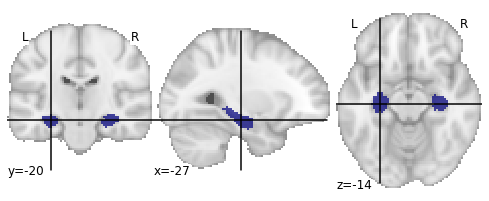

In [27]:
## Hippocampus
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/hippocampus_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=15", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None,
                                        standardize=False, detrend=False, verbose=5)

In [28]:
mean_act_hippo = []
scr_id = []
for func in func_files:
    # get subject number
    scr_id.append('KPE' + func.split('id_')[1].split('/')[0])
    # get average activation
    t_map = masker.fit_transform(func)
    
    average = np.mean(np.array(t_map))
    mean_act_hippo.append(average)


[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning 

[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] 

In [29]:
df_ses2['hippo2'] = mean_act_hippo

In [31]:
pg.ttest(df_ses2.hippo2[df_ses2.group=='ketamine'],df_ses2.hippo2[df_ses2.group=='midazolam'] )

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.981541,22.777227,two-sided,0.059727,"[-42.73, 0.93]",0.79376,1.462,0.476077


In [ ]:
df_ses3.groupby('group').describe()

In [ ]:
sns.barplot(x='group',y='hippo3', data=df_ses3, ci=95)
scipy.stats.ttest_ind(df_ses3.hippo3[df_ses3['group']=='ketamine'],
                      df_ses3['hippo3'][df_ses3['group']=='midazolam'])

In [ ]:
df['hippo_21'] = df.hippo2 - df.hippo1
sns.barplot(x='group',y='hippo_21', data=df, ci=68)
scipy.stats.ttest_ind(df.hippo_21[df['group']=='ketamine'], df['hippo_21'][df['group']=='midazolam'])

In [ ]:
with pm.Model() as model_glm:
    GLM.from_formula('hippo3 ~ groupIdx', df_ses3)
    trace_hippo = pm.sample(draws=2000, tune=2000,random_seed=113)
pm.summary(trace_hippo, hdi_prob=.95).round(2)

In [ ]:
# set variables
sns.set_style("ticks")
y = 'hippo'
dfPlot = df
ci = np.quantile(trace_hippo.groupIdx, [.025,.975])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                        'wspace':.1})
g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
            boxprops=dict(alpha=.3))
g2 = sns.distplot(trace_hippo['groupIdx'], ax = ax2, vertical=True)
ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
           linewidth = 2, linestyle = "-")


ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
ax2.yaxis.tick_right()
ax2.set_xticks([])
ax2.set_ylabel("Difference between groups", fontsize=14) 
ax2.yaxis.set_label_position("right")
ax1.set_ylabel("Hippocampus reactivity to traumatic script", fontsize=12)
ax1.set_xlabel("Group", fontsize=14)
fig.savefig('hippoReactivity.png', dpi=600, bbox_inches='tight')

In [ ]:
df.groupby('group').describe()